# Using a New Machine Learning Classifier

In this activity, you’ll evaluate how our earlier trading strategy behaves when it uses a different machine learning classification model.

## Instructions:

1. Run all the cells up to the “Add a New Machine Learning Model” section.

2. Import the `LogisticRegression` model from scikit-learn.

    > **Rewind** Recall that `LogisticRegression` models are used for binary classification problems.

3. Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

4. Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

5. Backtest the `LogisticRegression` model to evaluate its performance.

6. Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data.  Did the logistic regression model perform better than SVM?


## References:

[SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

[SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [1]:
# Imports
import pandas as pd
from pathlib import Path

### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../Resources/ohlcv.csv"), 
    index_col="date", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
trading_df.head()

,open,high,low,close,volume
date,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
date,,,,,,
2018-10-19 09:45:00,17.11,17.44,17.11,17.40,70593,0.017841
2018-10-19 10:00:00,17.40,17.40,17.25,17.28,38885,-0.006897
2018-10-19 10:15:00,17.27,17.27,17.18,17.20,37046,-0.004630
2018-10-19 10:30:00,17.21,17.37,17.19,17.20,46874,0.000000
2018-10-19 10:45:00,17.20,17.20,17.10,17.12,11266,-0.004651


,open,high,low,close,volume,actual_returns
date,,,,,,
2020-09-04 14:45:00,6.225,6.26,6.220,6.250,55512,0.003210
2020-09-04 15:00:00,6.255,6.27,6.245,6.250,65810,0.000000
2020-09-04 15:15:00,6.250,6.29,6.250,6.275,202630,0.004000
2020-09-04 15:30:00,6.270,6.28,6.250,6.255,130140,-0.003187
2020-09-04 15:45:00,6.250,6.28,6.250,6.250,190278,-0.000799


---

### Generating the Features and Target Sets

In [4]:
# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df['sma_fast'] = trading_df['close'].rolling(window=short_window).mean()

In [5]:
# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df['sma_slow'] = trading_df['close'].rolling(window=long_window).mean()

In [6]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [7]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[['sma_fast', 'sma_slow']].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
date,,
2018-10-24 15:00:00,15.65250,16.3403
2018-10-24 15:15:00,15.61875,16.3216
2018-10-24 15:30:00,15.55375,16.3029
2018-10-24 15:45:00,15.47625,16.2844
2018-10-25 09:30:00,15.40250,16.2656


,sma_fast,sma_slow
date,,
2020-09-04 14:45:00,6.22875,6.27030
2020-09-04 15:00:00,6.23875,6.26985
2020-09-04 15:15:00,6.25125,6.26910
2020-09-04 15:30:00,6.25750,6.26855
2020-09-04 15:45:00,6.25750,6.26785


#### Create the target set

In [8]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df['signal'] = 0.0

In [9]:
# Create the signal to buy
trading_df.loc[(trading_df['actual_returns'] >= 0), 'signal'] = 1

In [10]:
# Create the signal to sell
trading_df.loc[(trading_df['actual_returns'] < 0), 'signal'] = -1

In [11]:
# Copy the new signal column to a new Series called y.
y = trading_df['signal'].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [12]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [13]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-10-24 15:00:00


In [14]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-01-24 15:00:00


In [15]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
date,,
2018-10-24 15:00:00,15.65250,16.3403
2018-10-24 15:15:00,15.61875,16.3216
2018-10-24 15:30:00,15.55375,16.3029
2018-10-24 15:45:00,15.47625,16.2844
2018-10-25 09:30:00,15.40250,16.2656


#### Creating the Testing Datasets

In [16]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
date,,
2019-01-24 15:00:00,14.1600,14.29466
2019-01-24 15:15:00,14.1600,14.29036
2019-01-24 15:30:00,14.1575,14.28666
2019-01-24 15:45:00,14.1525,14.28161
2019-01-25 09:30:00,14.1750,14.27791


#### Standardizing the Data

In [17]:
# Imports
from sklearn.preprocessing import StandardScaler

In [18]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [19]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [20]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [21]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.55      0.17      0.26       741
         1.0       0.52      0.87      0.65       776

    accuracy                           0.53      1517
   macro avg       0.54      0.52      0.46      1517
weighted avg       0.54      0.53      0.46      1517



---

### Backtesting a Machine Learning Trading Algorithm

In [22]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [23]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.37      0.42      4894
         1.0       0.53      0.64      0.58      5559

    accuracy                           0.51     10453
   macro avg       0.50      0.50      0.50     10453
weighted avg       0.51      0.51      0.50     10453



In [24]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2019-01-24 15:00:00,1.0,0.002123,0.002123
2019-01-24 15:15:00,1.0,0.001412,0.001412
2019-01-24 15:30:00,1.0,-0.001410,-0.001410
2019-01-24 15:45:00,1.0,-0.003531,-0.003531
2019-01-25 09:30:00,1.0,0.009922,0.009922


<AxesSubplot:xlabel='date'>

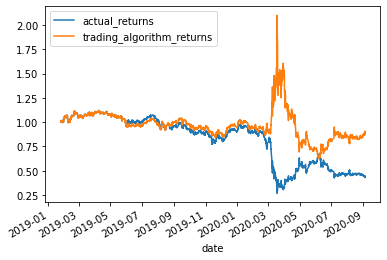

In [25]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Step 2: Import the `LogisticRegression` model from scikit-learn.


In [26]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [27]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

## Step 3: Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [28]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Step 4: Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [29]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Diplay the predictions
lr_training_signal_predictions

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [37]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.51      0.24      0.33       741
         1.0       0.52      0.77      0.62       776

    accuracy                           0.51      1517
   macro avg       0.51      0.51      0.47      1517
weighted avg       0.51      0.51      0.48      1517



## Step 5: Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [31]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [36]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.07      0.12      4894
         1.0       0.54      0.94      0.68      5559

    accuracy                           0.53     10453
   macro avg       0.53      0.51      0.40     10453
weighted avg       0.53      0.53      0.42     10453



## Step 6: Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [33]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.52      0.07      0.12      4894
         1.0       0.54      0.94      0.68      5559

    accuracy                           0.53     10453
   macro avg       0.53      0.51      0.40     10453
weighted avg       0.53      0.53      0.42     10453



In [34]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.37      0.42      4894
         1.0       0.53      0.64      0.58      5559

    accuracy                           0.51     10453
   macro avg       0.50      0.50      0.50     10453
weighted avg       0.51      0.51      0.50     10453



In [35]:
### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** Yes! The logistic regression model performs a bit better than the SVM model since it has a higher accuracy score.